# Interpreting Model Behavior

How do we understand how the model makes decisions? One window into the model's decision making process is to perturb the input sequence and see what effect that has on the predicted output. 



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx
import random
import seaborn as sns

In [3]:
sys.path.append("..")
from utils import *

In [4]:
path = Path('F:/genome/e_coli/')
path_bact = Path('F:/genome/bacterial genomes/')

In [5]:
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

In [6]:
classification_df.head()

,Gene,Locus,Location,Sample Location,Orientation,Sequence,Promoter,Independent,set
0,['mokC'],['b0018'],[16750:16960](-),[16910:17060](-),reverse,TAGCGGCGGGTGCTTGAGGCTGTCTGTCTCAGGCATTAGCTGAACG...,1,False,train
1,['insB-1'],['b0021'],[19810:20314](-),[20264:20414](-),reverse,GCTCTCACTGCCGTAAAACATGGCAACTGCAGTTCACTTACACCGC...,1,False,train
2,['insA-1'],['b0022'],[20232:20508](-),[20458:20608](-),reverse,GACTCCCCCACAAAGAATATGGATATTGTGATACACATTGAGGTAG...,1,False,train
3,['rpsT'],['b0023'],[20814:21078](-),[21028:21178](-),reverse,ACGGCGCTTATTTGCACAAATCCATTGACAAAAGAAGGCTAAAAGG...,1,False,train
4,['fkpB'],['b0028'],[25825:26275](+),[25725:25875](+),forward,ACGCATCTTATCCGGCCTACAGATTGCTGCGAAATCGTAGGCCGGA...,1,False,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
voc = np.load(path_bact/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.load('coli_bact_pretrain');

This is the class used to perturb the input sequence. It takes as input a query sequence, a list of lenghts for k-mer perturbations, and the ground truth class of the sequence. 

For each k-mer length in the `lengths` input, the class will create variants of the input sequence perturbed by a sliding window of length k that moves across the input sequence, creating variants perturbed at a known location in the sequence.

Perturbation k-mers of lengths corresponding to the `lengths` input can optionally be provided. If no perturbation k-mers are provided, the class will generate random perturbation k-mers. If `gen_rand` is set to `True`, a random k-mer will be generated for each perturbation. If `gen_rand` is set to `False`, one set random k-mer will be generated for each random length, and every purturbation will use the same generated k-mers.

Passing defined perturbation k-mers allows for probing how the classification model reacts to certain sequence motifs. Using randomly generated k-mers allows for probing how sensitive the classification model is to noise in the prediction sequence.

Optionally, if the location of a known transcription start site is known in the test sequence, it can be passed via `tss_loc`, and will be plotted on the output graph.

In [15]:
class SequenceShuffler():
    def __init__(self, sequence, lengths, sequence_class, tss_loc=None, inserts=None, gen_rand=False):
        
        if inserts is not None:
            assert len(lengths) == len(inserts), "Number of inserts should match number of kmer lengths"
            assert all(len(inserts[i]) == lengths[i] 
                       for i in range(len(lengths))), "Each insert kmer must match kmer length list"
        
        self.inserts = inserts
        self.sequence = sequence
        self.lengths = lengths
        self.sequence_class = sequence_class
        self.gen_rand = gen_rand
        self.tss_loc = tss_loc
        self.get_dfs()

    def rand_sequence(self, length):
        return ''.join(random.choice('CGTA') for _ in range(length))
    
    def shuffle_section(self, length, idx):
        if self.const_insert:
            insert = self.const_insert
        else:
            insert = self.rand_sequence(length)
            
        return (''.join([self.sequence[:idx], insert, self.sequence[idx+length:]]), insert)
    
    def get_shuffles(self, length):
        seqs = []
        idxs = []
        inserts = []

        for i in range(len(self.sequence)-length+1):
            seq, insert = self.shuffle_section(length, i)
            seqs.append(seq)
            inserts.append(insert)
            idxs.append(i)

        return (seqs, idxs, inserts)
    
    def get_shuffle_df(self, length):
        
        if self.inserts is not None:
            self.const_insert = self.inserts[self.lengths.index(length)]
        
        elif not self.gen_rand:
            self.const_insert = self.rand_sequence(length)
            
        else:
            self.const_insert = False
        
        seqs, idxs, inserts = self.get_shuffles(length)

        seq_df = pd.DataFrame(seqs, columns=['Sequence'])
        seq_df['length'] = length
        seq_df['position'] = idxs
        seq_df['plot_position'] = seq_df['position'].map(lambda x: x + length/2)
        seq_df['insert'] = inserts

        return seq_df
    
    def get_dfs(self):
        self.df = pd.concat([self.get_shuffle_df(i) for i in self.lengths])
        self.df['Promoter'] = self.sequence_class
        
    def get_predictions(self, learn, path, train_df, tok, model_vocab, label):
        data = GenomicTextClasDataBunch.from_df(path, train_df, self.df, tokenizer=tok, vocab=model_vocab,
                                                    text_cols='Sequence', label_cols=label, bs=300)
        learn.data = data
        preds = learn.get_preds(ordered=True)
        self.df['Probability'] = preds[0][:,1]
        
    def plot_results(self):
        plt.figure(figsize=(15,8))
        palette = sns.color_palette("mako_r", len(self.lengths))
        ax = sns.lineplot(x="plot_position", y="Probability", data=self.df, hue='length', palette=palette)
        if self.tss_loc is not None:
            plt.axvline(self.tss_loc, color='r')

In [15]:
def plot_shuffle(idx, lengths, tss=None, inserts=None, gen_rand=False, ret=False, label='Promoter'):
    SeqShuffle = SequenceShuffler(classification_df.Sequence[idx], lengths, classification_df.Promoter[idx],
                                  tss_loc=tss, inserts=inserts, gen_rand=gen_rand)
    SeqShuffle.get_predictions(learn, path, train_df, tok, model_vocab, label)
    SeqShuffle.plot_results()
    
    if ret:
        return SeqShuffle

# Promoter Sequences

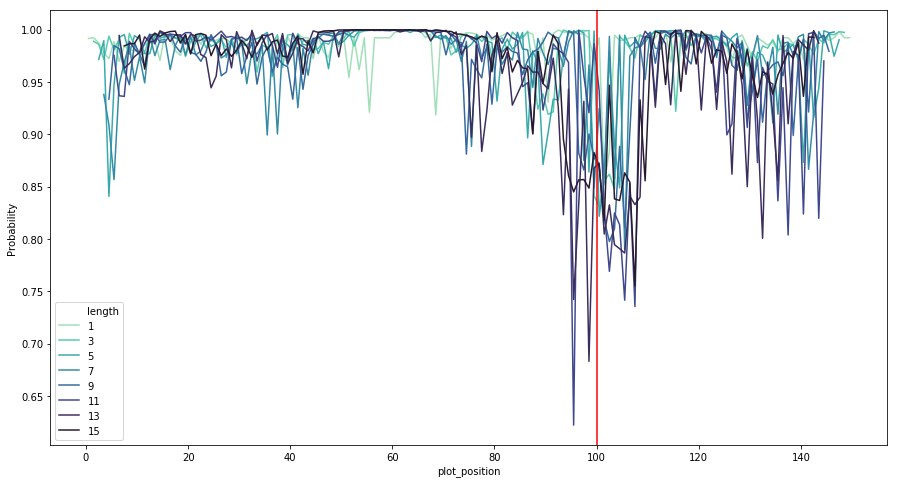

In [16]:
plot_shuffle(0, list(range(1,16,2)), 100)

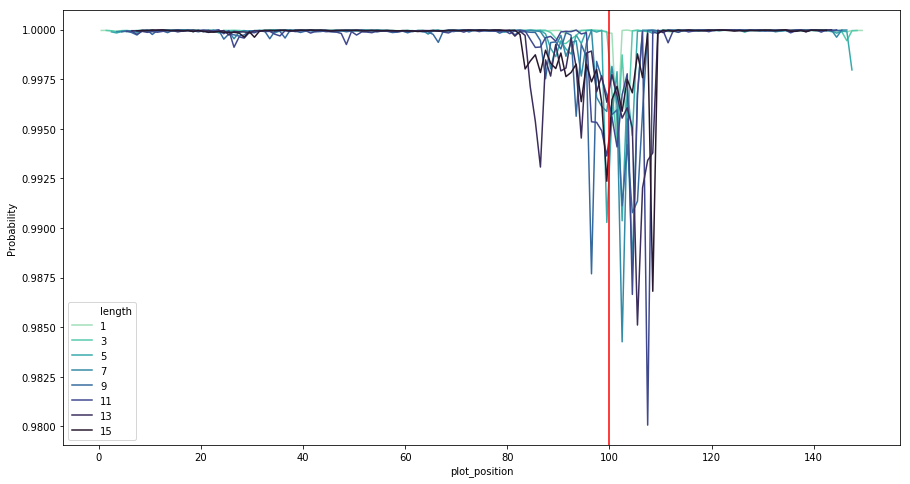

In [17]:
plot_shuffle(10, list(range(1,16,2)), 100)

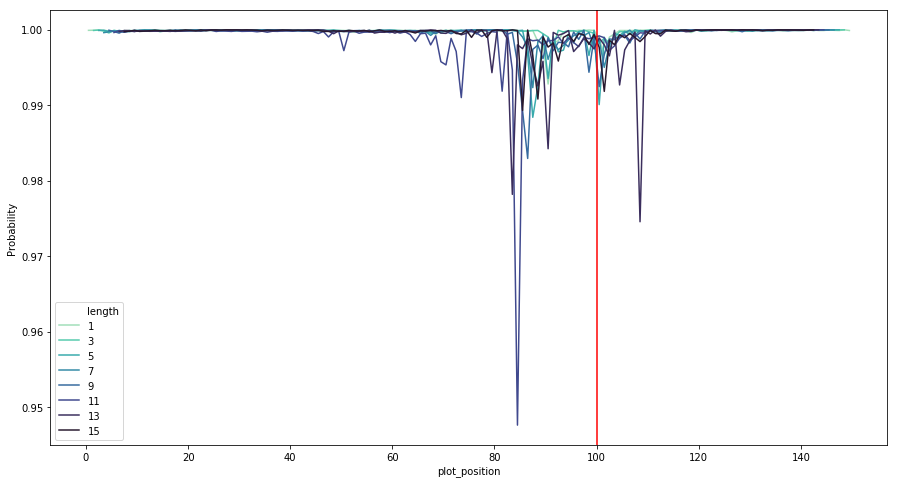

In [18]:
plot_shuffle(1000, list(range(1,16,2)), 100)

# Non-Promoter Sequences

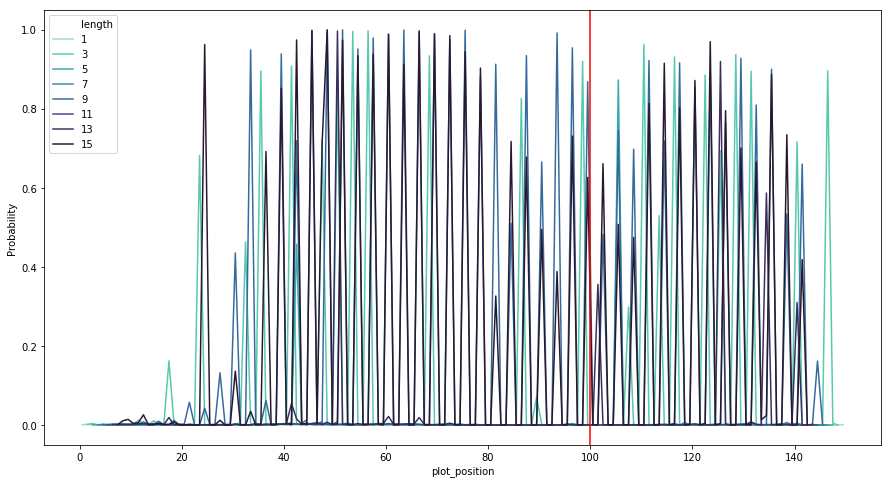

In [19]:
plot_shuffle(6000, list(range(1,16,2)), 100)

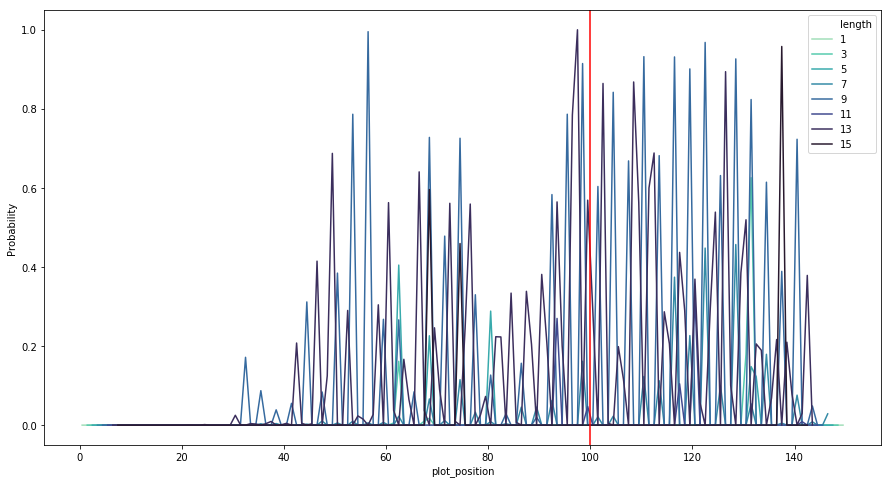

In [20]:
plot_shuffle(7000, list(range(1,16,2)), 100)

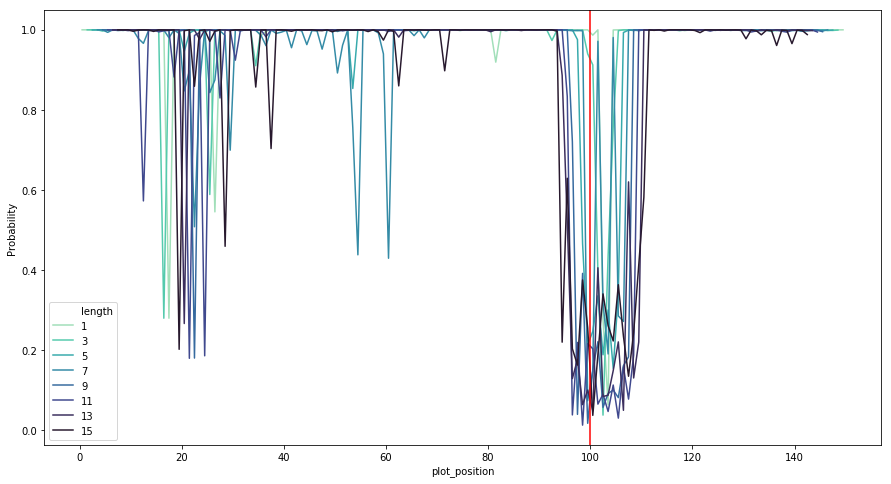

In [21]:
plot_shuffle(8000, list(range(1,16,2)), 100)

# Fixed Perturbation k-mers

In [22]:
inserts = ['G', 'TGA', 'ATGAA', 'AATGAAT', 'CAATGAATA', 'CCAATGAATAA', 'CCCAATGAATAAT', 'ACCCAATGAATAATC']

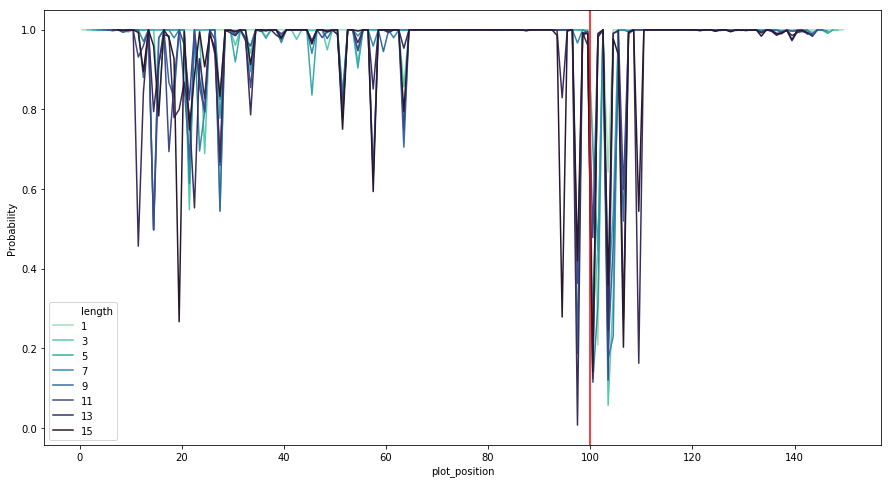

In [23]:
shuf = plot_shuffle(8000, list(range(1,16,2)), 100, inserts=inserts, ret=True)